之前那个先验实在效果不行，随机初始化不是插进去就是滑出去，不过先验加的太硬又有一种硬点的感觉。说明这个模型有些本质上的缺陷，
加个硬先验混完这个案例研究我就搞其他东西去了。先翻译完那个东西再试试那个样本驱动方法做这种模型。

突然发现那个效果之所以那么烂是因为出了个异常值，改掉（这是不是也有一种钦定的感觉）就好了。

那下面改成体现加权效果的版本

In [1]:
import bayestorch as bt
from bayestorch import Parameter,Data,Variable,optimizing,vb,sampling,reset
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch


In [2]:
%matplotlib inline

In [3]:
from bayestorch.data.gettysburg import Confederate,Confederate_name,Confederate_number,Union,Union_name,Union_number


In [4]:
maxy = max(Confederate[:,1].max(),Union[:,1].max())

In [5]:
Confederate = Confederate.astype('float')
Union = Union.astype('float')
Confederate_number = Confederate_number.astype('float')
Union_number = Union_number.astype('float')

size_x = 0.1
size_y = 0.1
Confederate[:,0] *= size_x
Confederate[:,1] *= size_y
Union[:,0] *= size_x
Union[:,1] *= size_y


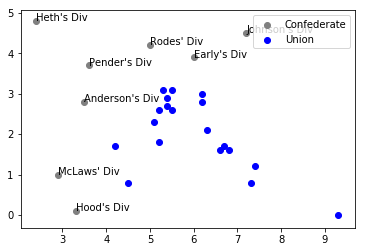

In [6]:
def show_name(show_Confederate=True,show_Union=True):
    if show_Confederate:
        for idx,name in enumerate(Confederate_name):
            i,j = Confederate[idx]
            plt.text(i,j,name)
    if show_Union:
        for idx,name in enumerate(Union_name):
            i,j = Union[idx]
            plt.text(i,j,name)

def display_data(name=False):
    plt.scatter(Confederate[:,0],Confederate[:,1],label='Confederate',color='grey')
    plt.scatter(Union[:,0],Union[:,1],label='Union',color='blue')
    if name:
        show_name(show_Union=False)

display_data(name=True)
plt.legend()
plt.show()



In [7]:
friend_point = Union
enemy_point = Confederate
_enemy_point = enemy_point.copy()

In [8]:
# transformed data

X = np.vstack([friend_point, enemy_point])
Y = np.ones(X.shape[0],dtype=int)
Y[:friend_point.shape[0]] = 0


_logPC = np.log(np.array([np.sum(Y==0)/len(Y),np.sum(Y==1)/len(Y)]))


In [9]:
from bayestorch.distributions import norm_log_prob
from bayestorch.classifier import norm_naive_bayes_predict
from bayestorch.utils import GridSampler2d,cdist,soft_cut_ge,soft_cut_le

model = bt.core.current_model

In [67]:
Confederate_weight = Confederate_number/ Confederate_number.sum()
Union_weight = Union_number/ Union_number.sum()

Confederate_dist_factor = 6000/Confederate_number
Union_dist_factor = 6000/Union_number


In [10]:
_x = np.linspace(2,10,100)
_y = np.linspace(-1,5,100)

xx,yy = np.meshgrid(_x,_y)
xy = np.c_[xx.ravel(),yy.ravel()]

In [81]:
# model for forward
reset()

friend = Data(friend_point)
battle = Data(xy)
enemy = Parameter(enemy_point) # set real value as init value, though maybe a randomed init is more proper

enemy_weight = Data(Confederate_weight)
friend_weight = Data(Union_weight)
enemy_dist_factor = Data(Confederate_dist_factor)
friend_dist_factor = Data(Union_dist_factor)


logPC = Data(_logPC)

conflict_threshold = 0.2
distance_threshold = 1.0
tense = 10.0
alpha = 5.0
prior_threshold = 5.0
prior_tense = 5.0

def target_p():
    friend_enemy = torch.cat((friend, enemy),0)
    friend_enemy_dist_factor = torch.cat((friend_dist_factor,enemy_dist_factor),0)
    
    distance = (cdist(battle, friend_enemy)*friend_enemy_dist_factor).min(dim=1)[0]
    #distance = distance * friend_enemy_dist_factor

    mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
    sd = Variable(torch.zeros(2,2))
    '''
    mu[0,:] = friend.mean(dim=0)
    mu[1,:] = enemy.mean(dim=0)
    sd[0,:] = friend.std(dim=0)
    sd[1,:] = enemy.std(dim=0)
    '''
    _friend_weight = torch.unsqueeze(friend_weight,1)
    _enemy_weight  = torch.unsqueeze(enemy_weight, 1)
    
    mu[0,:] = torch.sum(friend * _friend_weight,dim=0)
    mu[1,:] = torch.sum(enemy  * _enemy_weight, dim=0)
    sd[0,:] = torch.sqrt(torch.sum((friend - mu[0,:])**2 * _friend_weight, dim=0))
    sd[1,:] = torch.sqrt(torch.sum((enemy  - mu[1,:])**2 * _enemy_weight, dim=0))
    
    conflict = torch.exp(norm_naive_bayes_predict(battle, mu, sd, logPC)).prod(dim=1)
    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)
    return p

def target():
    p = target_p()
    
    target= torch.sum(torch.log(p))
    return target

In [82]:
prob = target_p().data.numpy().reshape(xx.shape)

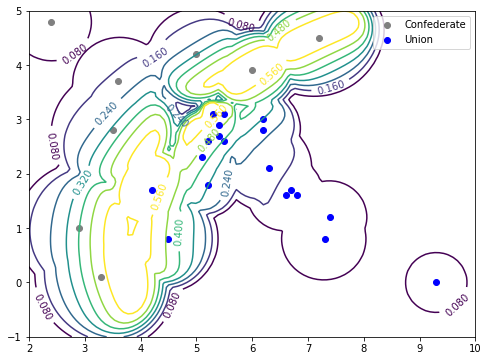

In [83]:
plt.figure(figsize=(8,6))

CS = plt.contour(xx,yy,prob)
#plt.contour(xx, yy, p_exist)
plt.clabel(CS)
display_data()
plt.legend()
plt.show()

In [14]:
len(Confederate)

8

In [15]:
len(Union)

19

In [16]:
Confederate_number

array([4628., 6762., 6957., 6686., 5080., 5202., 4572., 6012.])

In [17]:
Union_number

array([4913., 5008., 3558., 3622., 3303., 1633., 2264., 2922., 1475.,
       1311., 1697., 3851., 4698., 3990., 3411., 2842., 4729., 4181.,
       3548.])

In [ ]:
''''''
prob /= prob.sum()
from bayestorch.utils import GridSampler2d
sampler = GridSampler2d(lambda xy:prob.reshape((np.prod(xx.shape))), _x, _y)

In [18]:
import pandas as pd

In [43]:
Confederate_df = pd.DataFrame(dict( strength = Confederate_number.astype(int), x = Confederate[:,0],y = Confederate[:,1]),index=Confederate_name)

In [44]:
Confederate_df.transpose()

,Heth's Div,McLaws' Div,Hood's Div,Anderson's Div,Pender's Div,Rodes' Div,Early's Div,Johnson's Div
strength,4628.0,6762.0,6957.0,6686.0,5080.0,5202.0,4572.0,6012.0
x,2.4,2.9,3.3,3.5,3.6,5.0,6.0,7.2
y,4.8,1.0,0.1,2.8,3.7,4.2,3.9,4.5


In [46]:
Union_df = pd.DataFrame(dict( strength = Union_number.astype(int), x = Union[:,0],y = Union[:,1]),index=Union_name)

In [47]:
Union_df

,strength,x,y
2nd D (Humphreys),4913,4.2,1.7
1st Div (Birney),5008,4.5,0.8
2nd Div (Gibbon),3558,5.1,2.3
3rd Div (Hays),3622,5.2,2.6
1st Div (Caldwell),3303,5.2,1.8
3rd Div (Schurz),1633,5.3,3.1
2nd Div (Steinwehr),2264,5.4,2.9
3rd Div (Doubleday),2922,5.4,2.7
1st Div (Barlow),1475,5.5,3.1
2nd Div (Robinson),1311,5.5,2.6


In [49]:
#print(Union_df.to_latex())

In [50]:
battle_point = np.array([[ 8.92149988, 4.7647852],
       [ 3.770348  ,  2.0003748 ],
       [ 6.28196513,  4.07026271],
       [ 3.75463152,  0.85327729],
       [ 5.70194886,  2.98669733],
       [ 6.3262454 ,  3.82138602],
       [ 5.22415519,  3.53334417],
       [ 3.74946263,  0.55205848],
       [ 3.36890655,  0.87741923],
       [ 4.57859071,  3.88095631]])


In [58]:
def reset_enemy(_enemy_point):
    global friend,battle,enemy,logPC
    global enemy_point
    global enemy_weight,friend_weight,enemy_dist_factor,friend_dist_factor
    reset() #状态机模型只能这么写了，感觉这么设计还是不好。。要么和闭包什么什么打交道更日dog
    enemy_point = _enemy_point
    
    friend = Data(friend_point)
    battle = Data(battle_point)
    enemy = Parameter(_enemy_point) # set real value as init value, though maybe a randomed init is more proper
    logPC = Data(_logPC)
    
    enemy_weight = Data(Confederate_weight)
    friend_weight = Data(Union_weight)
    enemy_dist_factor = Data(Confederate_dist_factor)
    friend_dist_factor = Data(Union_dist_factor)



In [84]:
# model for backward
reset()

friend = Data(friend_point)
battle = Data(battle_point)
enemy = Parameter(enemy_point) # set real value as init value, though maybe a randomed init is more proper

logPC = Data(_logPC)

conflict_threshold = 0.2
distance_threshold = 1.0
tense = 10.0
alpha = 5.0
prior_threshold = 5.0
prior_tense = 5.0


In [85]:
def show_change(show=False):
    display_data()
    for i in range(enemy_point.shape[0]):
        #s = 0.1
        plt.arrow(enemy_point[i][0], enemy_point[i][1], enemy.data[i][0] - enemy_point[i][0], enemy.data[i][1] - enemy_point[i][1],head_width=0.1)
    plt.legend()
    if show:
        plt.show()


def show_ellipse(mu,sd):
    from matplotlib.patches import Ellipse
    
    #ax = plt.subplot(111)
    ax = plt.gca() # get current axe, the lame method to support command style
    show_change(show=False)
    #res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    for i in range(enemy_point.shape[0]):
        mu_x,mu_y = mu[i]
        sd_x,sd_y = sd[i]
        e=Ellipse((mu_x,mu_y), sd_x, sd_y, 0)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.1)
        ax.add_artist(e)
        
    #plt.show()
    
    
def show_vb(vb_res):
    res = vb_res
    model.set_parameter(res[0])
    res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    mu = res_reshaped[0]
    sd = np.exp(res_reshaped[1])
    show_ellipse(mu,sd)


In [86]:
import scipy.stats as stats

def prob_point(x,y,dx,dy,_mu,_omega):
    """计算各个潜在敌人点在指定区域出现的后验概率"""
    mu = _mu.reshape(enemy_point.shape)
    sigma = np.exp(_omega.reshape(enemy_point.shape))
    x = np.reshape(x,(-1,1))
    y = np.reshape(y,(-1,1))
    px  = stats.norm.cdf((x-mu[:,0])/sigma[:,0])
    pdx = stats.norm.cdf((x+dx-mu[:,0])/sigma[:,0])
    py  = stats.norm.cdf((y-mu[:,1])/sigma[:,1])
    pdy = stats.norm.cdf((y+dy-mu[:,1])/sigma[:,1])
    return (pdx - px) * (pdy - py) #wrong computation method

def prob_exist(x,y,dx,dy,_mu,_omega):
    ememy_prob = prob_point(x,y,dx,dy,_mu,_omega)
    return 1-np.prod((1 - ememy_prob).T,axis=0) #这么写是为了同时处理向量的矩阵对最后一维求prod

def prob_exist_limit(x,y,_mu,_omega,step=0.1):
    p = prob_exist(x-step,y-step,2*step,2*step,_mu,_omega)
    return p/(4*step*step)

In [87]:
def multi_enemy_setting_show_exist_density(_enemy_point, target, title_string,**kwargs):
    reset_enemy(_enemy_point)
    res = vb(target,**kwargs)
    show_vb(res)
    p_exist = prob_exist_limit(xy[:,0],xy[:,1],res[0],res[1],step=0.001).reshape(xx.shape)
    CS = plt.contour(xx,yy,p_exist)
    #plt.contour(xx, yy, p_exist)
    plt.clabel(CS)
    #plt.title(title_string.format(i))
    plt.gca().set_title(title_string.format(i))
    plt.legend()


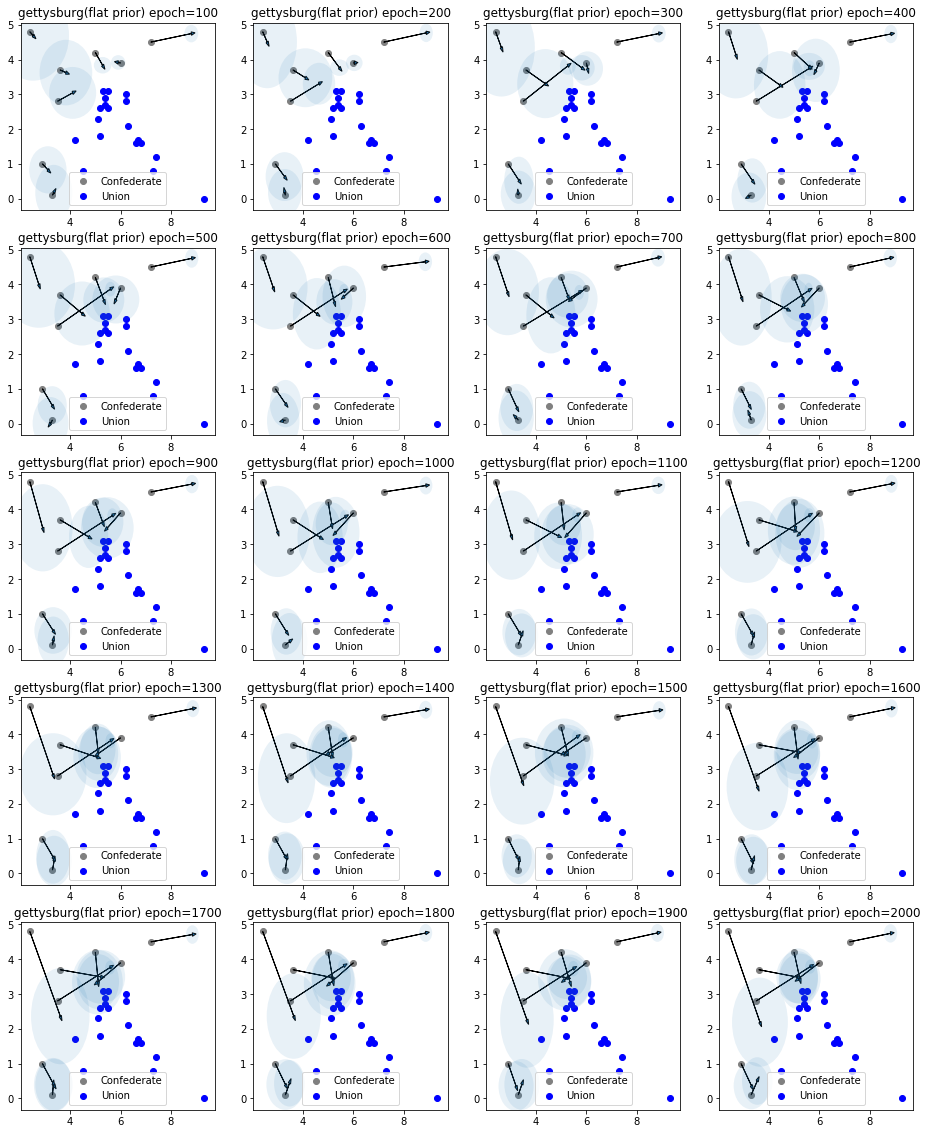

In [88]:
#_enemy_point = random_init(8)
reset_enemy(_enemy_point)

plt.figure(figsize=(16,20))

for i in range(20):
    res = vb(target, n_epoch=100)
    plt.subplot(5,4,i+1)
    show_vb(res)
    plt.legend()
    plt.gca().set_title('gettysburg(flat prior) epoch={}'.format((i+1)*100))
    #plt.show()
    model.set_parameter(res[0])
plt.show()

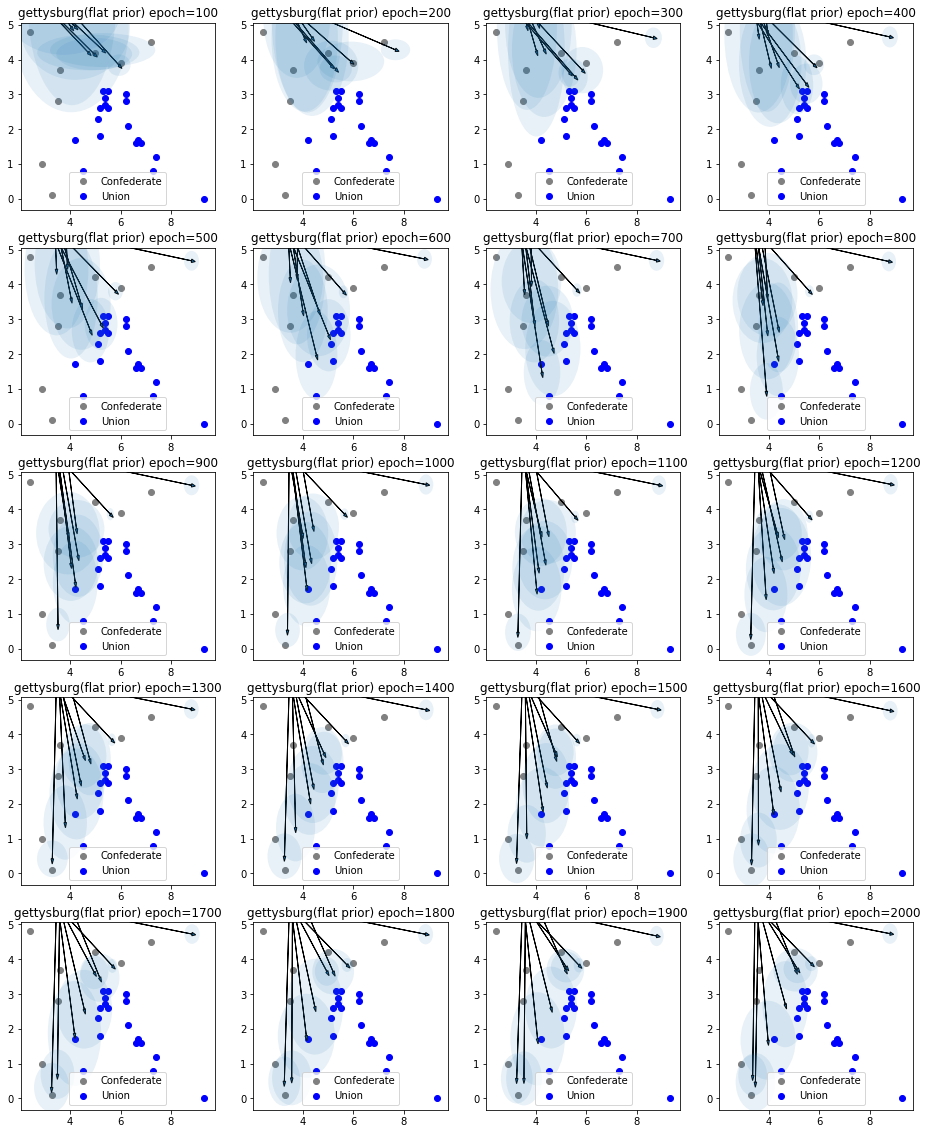

In [89]:
__enemy_point = np.random.random(size=_enemy_point.shape)+np.array([3,5])

reset_enemy(__enemy_point)

plt.figure(figsize=(16,20))

for i in range(20):
    res = vb(target, n_epoch=100)
    plt.subplot(5,4,i+1)
    show_vb(res)
    plt.legend()
    plt.gca().set_title('gettysburg(flat prior) epoch={}'.format((i+1)*100))
    #plt.show()
    model.set_parameter(res[0])
plt.show()

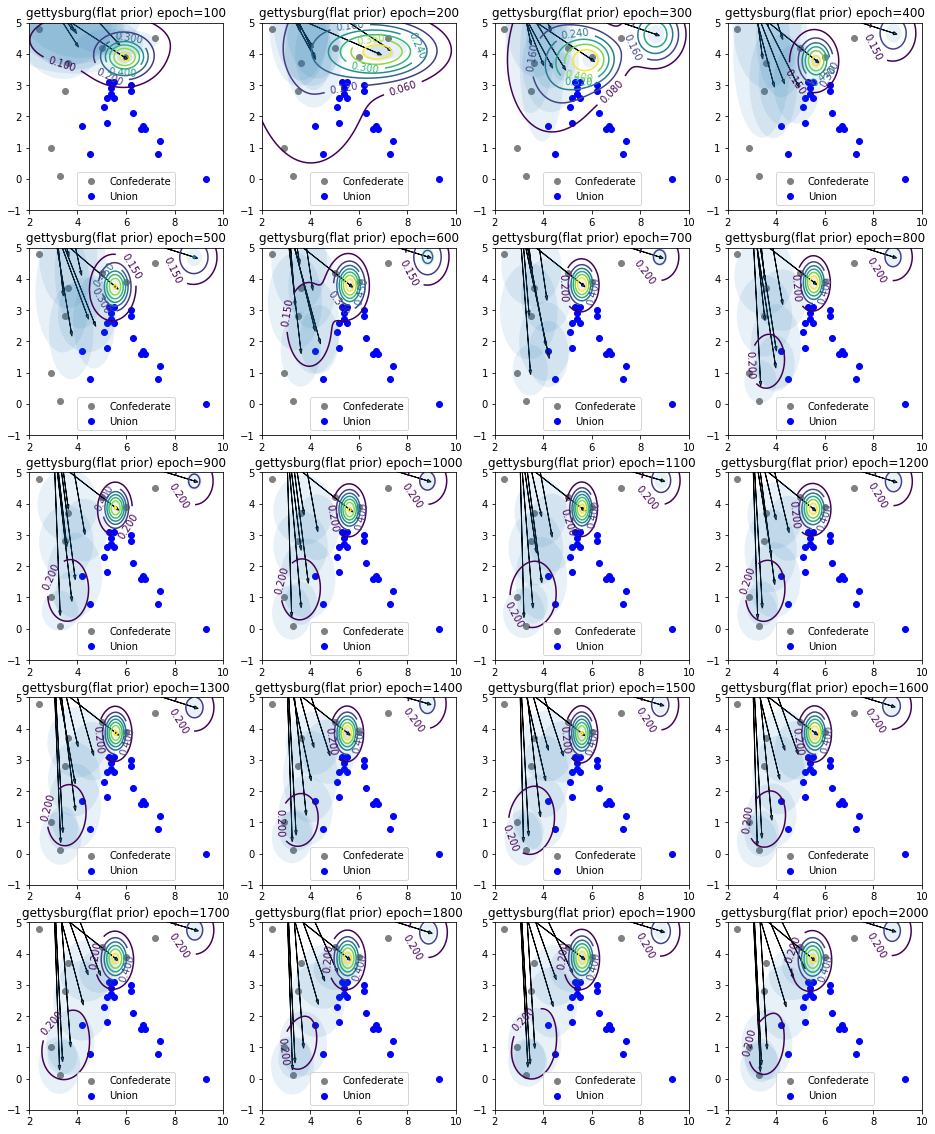

In [91]:
__enemy_point = np.random.random(size=_enemy_point.shape)+np.array([3,5])

reset_enemy(__enemy_point)

plt.figure(figsize=(16,20))

for i in range(20):
    res = vb(target, n_epoch=100)
    p_exist = prob_exist_limit(xy[:,0],xy[:,1],res[0],res[1],step=0.001).reshape(xx.shape)
    
    plt.subplot(5,4,i+1)
    show_vb(res)
    CS = plt.contour(xx,yy,p_exist)
    plt.clabel(CS)
    plt.legend()
    plt.gca().set_title('gettysburg(flat prior) epoch={}'.format((i+1)*100))
    
    model.set_parameter(res[0])
plt.show()

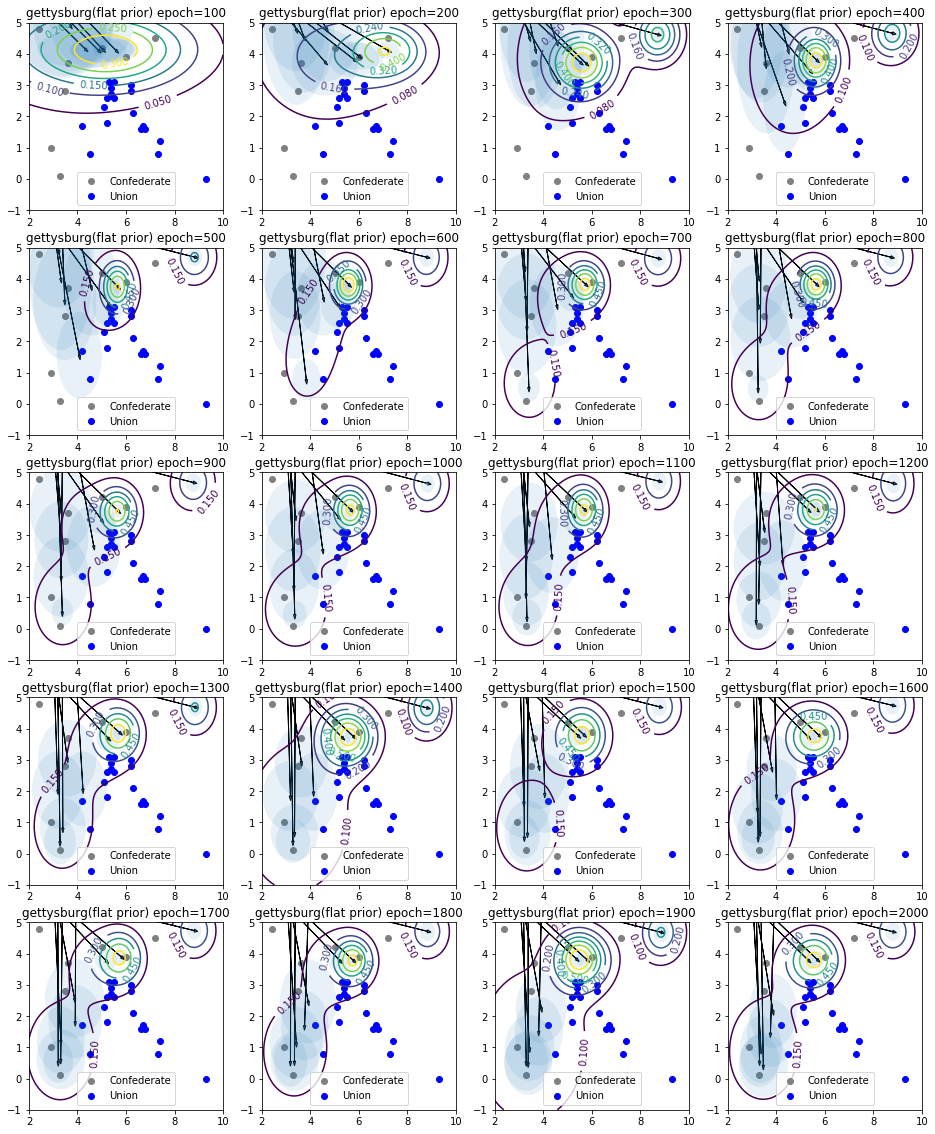

In [92]:
__enemy_point = np.random.random(size=_enemy_point.shape)+np.array([3,5])

reset_enemy(__enemy_point)

plt.figure(figsize=(16,20))

for i in range(20):
    res = vb(target, n_epoch=100)
    p_exist = prob_exist_limit(xy[:,0],xy[:,1],res[0],res[1],step=0.001).reshape(xx.shape)
    
    plt.subplot(5,4,i+1)
    show_vb(res)
    CS = plt.contour(xx,yy,p_exist)
    plt.clabel(CS)
    plt.legend()
    plt.gca().set_title('gettysburg(flat prior) epoch={}'.format((i+1)*100))
    
    model.set_parameter(res[0])
plt.show()

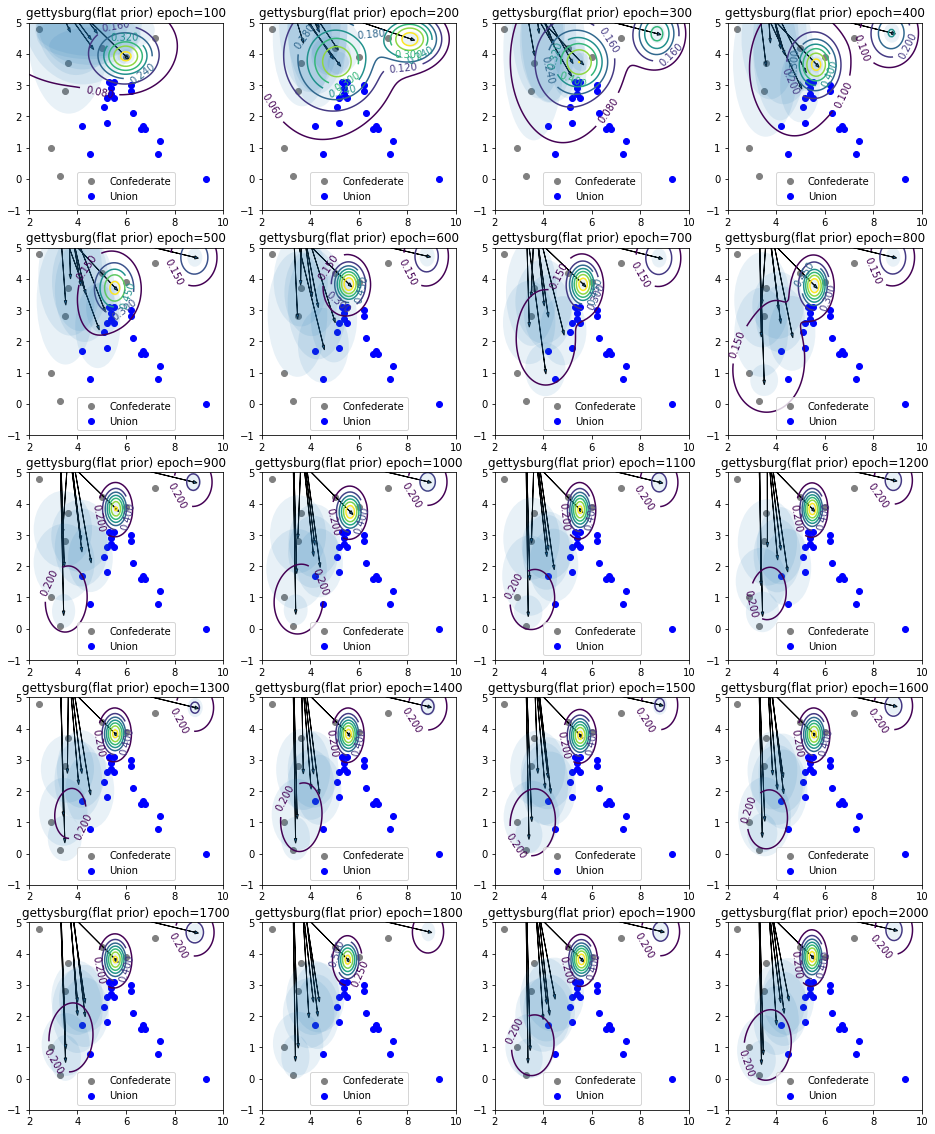

In [93]:
__enemy_point = np.random.random(size=_enemy_point.shape)+np.array([3,5])

reset_enemy(__enemy_point)

plt.figure(figsize=(16,20))

for i in range(20):
    res = vb(target, n_epoch=100)
    p_exist = prob_exist_limit(xy[:,0],xy[:,1],res[0],res[1],step=0.001).reshape(xx.shape)
    
    plt.subplot(5,4,i+1)
    show_vb(res)
    CS = plt.contour(xx,yy,p_exist)
    plt.clabel(CS)
    plt.legend()
    plt.gca().set_title('gettysburg(flat prior) epoch={}'.format((i+1)*100))
    
    model.set_parameter(res[0])
plt.show()